# Lab 3: Self-Supervised Learning

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install pyarrow

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b33fr73t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b33fr73t
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import os
import io
import clip
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from torch.nn.functional import softmax
from torch.optim import SGD

import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

CLASSES_FOOD101 = [
        "frozen yogurt", "tacos","gnocchi", "ramen", "sushi", "spaghetti carbonara", "foie gras", "club sandwich",
        "chicken curry", "caprese salad", "guacamole", "fish and chips", "seaweed salad", "samosa", "shrimp and grits",
        "prime rib", "cheese plate", "grilled cheese sandwich", "omelette", "macarons", "pancakes", "paella",
        "crab cakes", "onion rings", "poutine", "panna cotta", "hamburger", "eggs benedict", "pizza", "cup cakes",
        "red velvet cake", "huevos rancheros", "french toast", "pad thai","beef tartare", "beet salad",
        "garlic bread", "escargots", "cheesecake", "tuna tartare", "french fries", "pulled pork sandwich", "ravioli",
        "clam chowder", "baby back ribs", "pork chop", "chicken quesadilla", "grilled salmon", "dumplings",
        "fried rice", "macaroni and cheese", "hot and sour soup", "tiramisu",  "lobster_roll_sandwich",
        "filet mignon",  "lobster bisque",  "risotto",  "takoyaki",  "waffles",  "miso soup",  "scallops",
        "hummus", "french onion soup", "spaghetti bolognese", "gyoza", "sashimi", "caesar salad",
        "donuts", "pho", "creme brulee", "edamame","apple pie", "carrot cake", "croque madame",
        "chocolate_cake", "mussels", "chocolate mousse", "deviled eggs", "ice cream",
        "chicken_wings", "steak", "churros", "beignets", "breakfast burrito", "spring rolls",
        "lasagna", "cannoli", "nachos", "bruschetta", "hot dog", "greek salad", "beef carpaccio",
        "falafel", "strawberry shortcake", "bread pudding", "ceviche", "peking duck",
        "bibimbap", "oysters", "fried calamari", "baklava"
    ]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Introduction

In this lab, we will explore the principles and practical applications of self-supervised learning, first in a uni-modal setting, and then in a multimodal setting. We will focus on the SimCLR and CLIP models respectively.


### Objectives
- Exploring self-supervised learning
- Handling multimodal data  

# Part 1. Unimodal Self-Supervised Learning: SimCLR

## How SimCLR works?
SimCLR, short for Simple Framework for Contrastive Learning of Visual Representations, is a self-supervised learning method designed to train deep neural networks without labeled data. It enables models to learn meaningful visual representations by contrasting positive pairs (augmented views of the same image) against negatives.



<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-02_at_4.31.34_PM_7zlWDQE.png" width=300>

Figure: A simple framework for contrastive learning of visual representation [Chen et al, 2020]

In practice, SimCLR relies on:

1. Data Augmentation:
Randomly sample a minibatch $B$ of samples, and apply two different data augmentations to each sample $x$, resulting in $2N$ augmented samples:

$\tilde{x_i}=t(x), \tilde{x_j}=t'(x), t,t' \sim T$

where $t,t'$ are two separate data augmentation operators, sampled from the same family of augmentation $T$.
Data augmentation includes random crop, resize with random flip, color distortions, and Gaussian blur.

2. Given one positive pair, other
 data points are treated as negative samples. The representation is produced by a base encoder $f(.)$ (e.g. ResNet-18):

$h_i = f(\tilde{x_i}), h_j = f(\tilde{x_j})$

3. The contrastive learning loss is defined using cosine similarity $\text{sim}(.,.)$. The loss is computed on an projection layer of the representation  rather than on the representation space directly. The representation $h$ is used for downstream tasks.

$L_\text{simclr}^{(i,j)} = -\text{log} \frac{\text{exp}( \text{sim}(z_i, z_j)/ \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \text{exp}( \text{sim}(z_i, z_k)/ \tau)}$, $\mathbb{1}_{[k \neq i]}$ the indicator function, 1 if $k \neq i$ 0 otherwise.



For more details see: https://arxiv.org/pdf/2002.05709



Self-supervised learning (SSL) approaches for image understanding have demonstrated state-of-the-art performance across various settings. These methods are particularly effective when trained on large-scale datasets containing millions of images, enabling the learning of general-purpose representations. To gain a practical understanding of these methodologies, we will experiment with CIFAR-100, a smaller-scale dataset that simplifies the exploration of SSL concepts while preserving their core principles.

We will compare a fully-supervised baseline with a backbone pretrained using SimCLR, followed by fine-tuning. This comparison will highlight some benefits of self-supervised pretraining.

### Question 1.1
Train a fully-supervised baseline on CIFAR-100.

Use the ResNet-18 on CIFAR-100 for 20 epochs and log both train and test loss and accuracy.
Hparameters are to be choosen to your discretion.

Tips.
- Use Adam with some weight decay to avoid overfitting
- You can use data augmentation strategy to avoid overfitting on the training data
- For the normalization values you use: `(0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)`

In [3]:
def supervised_baseline(n_epochs: int, batch_size: int, lr: float) -> None:
    """
     Train a fully-supervised baseline on CIFAR-100 using ResNet-18.

    Args:
        n_epochs (int): No of epochs for training.
        batch_size (int): Batch size for the DataLoader.
        lr (float): Learning rate for the optimizer.

    Returns:
        None: Prints the training and testing loss and accuracy at each epoch.
    """
    # - transformations
    train_transform = transforms.Compose([
                          transforms.RandomCrop(32, padding=4),  # Random cropping with padding
                          transforms.RandomHorizontalFlip(),    # Random horizontal flip
                          transforms.ToTensor(),                # Convert image to PyTorch tensor
                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                     ])

    test_transform = transforms.Compose([
                          transforms.ToTensor(),                # Convert image to PyTorch tensor
                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize
                     ])

    # - dataset and dataloader
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

    # - model
    model = torchvision.models.resnet18(pretrained=False) # load the architecture
    model.fc = nn.Linear(model.fc.in_features, 100) # change the output layer to match the number of classes

    # To complete
    model = model.to(device) # Move model to GPU/CPU

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Training Loop
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)  # Normalize loss by batch size
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)  # Total number of samples

        # Normalize loss per sample
        train_loss /= total_samples
        train_acc = train_correct / total_samples  # Accuracy

        # Evaluation
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)  # Normalize loss by batch size
                _, predicted = outputs.max(1)
                test_correct += predicted.eq(labels).sum().item()
                total_samples += labels.size(0)

        # Normalize loss per sample
        test_loss /= total_samples
        test_acc = test_correct / total_samples  # Accuracy

        # logging
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



In [4]:
lr = 0.001 # Hparam to complete
batch_size = 128 # Hparam to complete
n_epochs = 20 # Hparam to complete
supervised_baseline(n_epochs=n_epochs, lr=lr, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 3.7097, Train Acc: 0.1329, Test Loss: 3.3535, Test Acc: 0.1993
Epoch 2/20, Train Loss: 3.1364, Train Acc: 0.2262, Test Loss: 2.9148, Test Acc: 0.2637
Epoch 3/20, Train Loss: 2.7962, Train Acc: 0.2894, Test Loss: 2.6664, Test Acc: 0.3204
Epoch 4/20, Train Loss: 2.5853, Train Acc: 0.3289, Test Loss: 2.5197, Test Acc: 0.3520
Epoch 5/20, Train Loss: 2.4178, Train Acc: 0.3649, Test Loss: 2.4901, Test Acc: 0.3586
Epoch 6/20, Train Loss: 2.2779, Train Acc: 0.3969, Test Loss: 2.3637, Test Acc: 0.3900
Epoch 7/20, Train Loss: 2.1659, Train Acc: 0.4167, Test Loss: 2.2066, Test Acc: 0.4178
Epoch 8/20, Train Loss: 2.0731, Train Acc: 0.4401, Test Loss: 2.2301, Test Acc: 0.4168
Epoch 9/20, Train Loss: 1.9811, Train Acc: 0.4597, Test Loss: 2.1504, Test Acc: 0.4323
Epoch 10/20, Train Loss: 1.9034, Train Acc: 0.4788, Test Loss: 2.0700, Test Acc: 0.4568
Epoch 11/20, Train Loss: 1.8308, Train Acc: 0.4949, Test Loss: 2.0190, Test Acc: 0.4703
Epoch 12/20, Train Loss: 1.7704, Train Ac

Results:
```
Hyperparameter:
lr = 0.001
batch_size = 128
n_epochs = 20
````
> Epoch 20/20, Train Loss: 5.178, Train Acc: 0.6164, Test Loss: 1.494, Test Acc: 0.5018

### Question 1.2
We need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a class that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class CustomTransform below.

Implement the Data Augmentation module.

In [5]:
class CustomTransform(object):
    """Custom Transform class for SimCLR"""
    def __init__(self, transform):
        """Initializes the transforms"""
        # To complete
        self.transform = transform

    def __call__(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Applies the two transformations to the input x

        __call__ method allows an instance of a class to
        be called as if it were a function.

        Parameters
        ----------
        x: torch.Tensor
            Input image tensor to be transformed

        Returns
        -------
        x1, x2: torch.Tensor, torch.Tensor
            Transformed images
        """
        # To complete
        x1 = self.transform(x)
        x2 = self.transform(x)
        return x1, x2

### Question 1.3

Plot a few pairs of transformed images from the dataset using `CustomTransform`

Tip. CIFAR-100 is a low resolution data set, thus images may appear highly pixelized.

In [6]:
base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5,
                                contrast=0.5,
                                saturation=0.5,
                                hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
paired_transformed = CustomTransform(base_transform) # Custom transform for SimCLR
train_set = torchvision.datasets.CIFAR100(root="./data",
                                          train=True,
                                          transform=paired_transformed,
                                          download=True)

Files already downloaded and verified


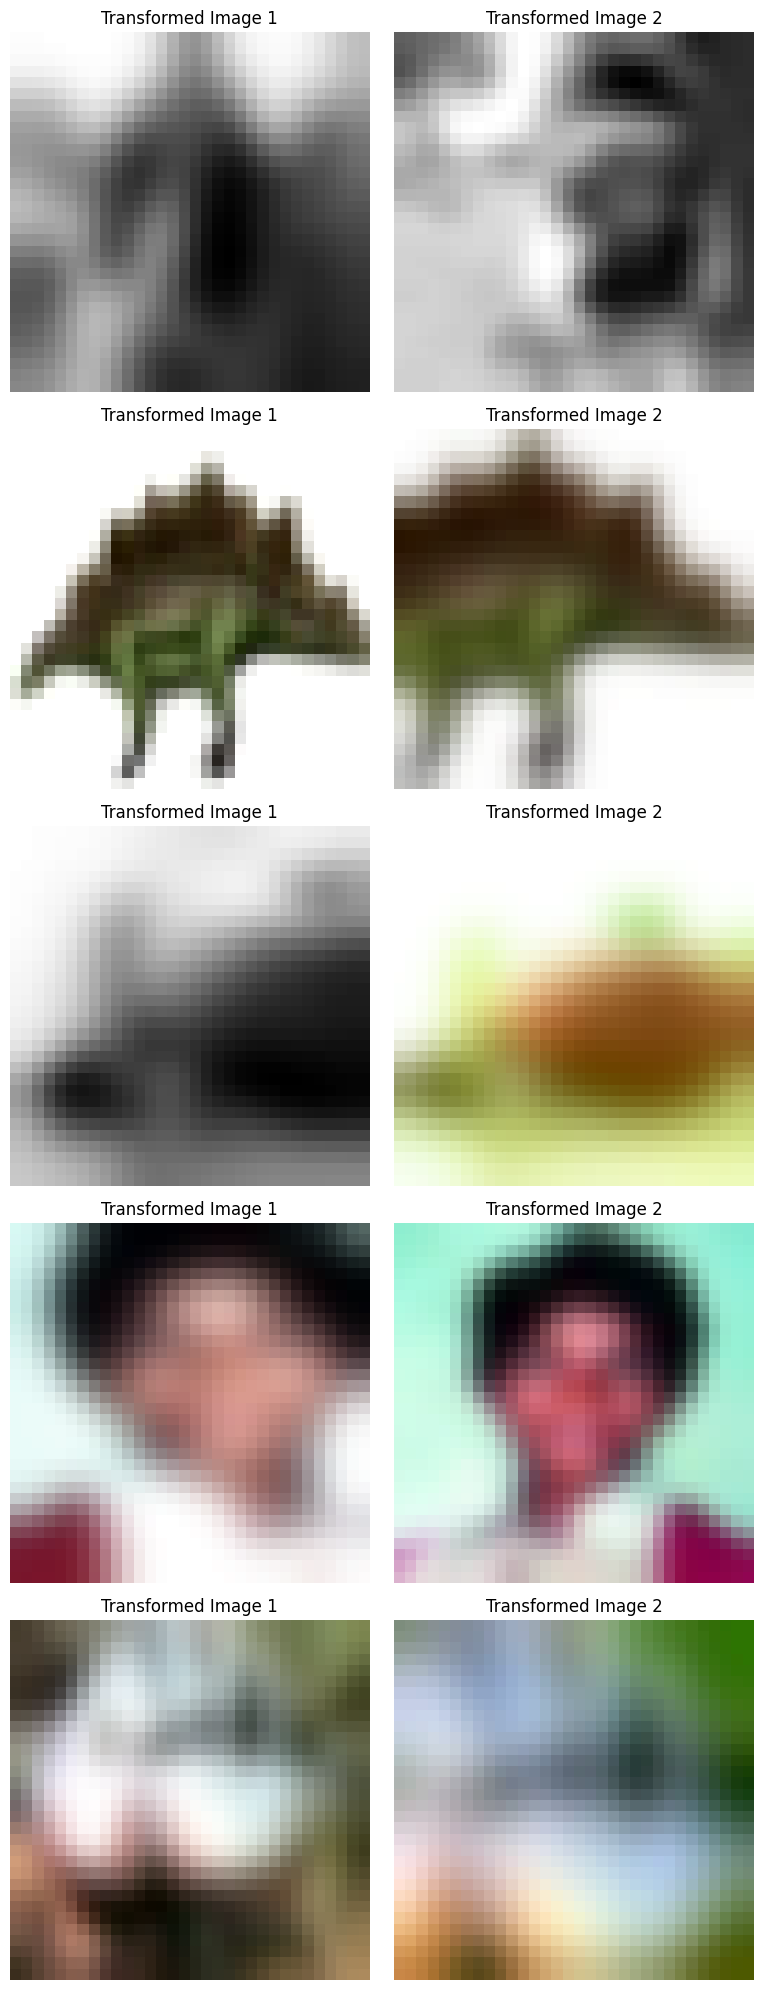

In [7]:
# to complete - plot the images
def plot_transformed_images(dataset, n_pairs = 5):
    """
    Plots pairs of transformed images from the dataset.

    Args:
        dataset: The dataset containing images with paired transforms.
        n_pairs (int): Number of image pairs to display.
    """
    fig, axes = plt.subplots(n_pairs, 2, figsize=(8, n_pairs * 4))

    for i in range(n_pairs):
        img1, img2 = dataset[i]  # Each dataset item is a pair of transformed images

        if isinstance(img1, tuple):  # Ensure images are properly extracted
            img1, img2 = img1  # Extract transformed images from the tuple

        if isinstance(img1, torch.Tensor):
            img1 = img1.permute(1, 2, 0).numpy()
            img2 = img2.permute(1, 2, 0).numpy()

        # Normalize images to 0-1 for visualization
        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())

        # Plot both transformed images
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title("Transformed Image 1")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title("Transformed Image 2")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Plot pairs of transformed images from the train_set
plot_transformed_images(train_set, n_pairs=5)

### Question 1.3

To implement the SimCLR architecture, we need a model composed of:
- the backbone $f$ (e.g. ResNet-18)
- the projection head ($g$), a two layer MLP.
- at each forward pass, return the represention ($h = f(x)$) and the projection ($z = g(h)$)

Implement the model.

Tip.
- Remove the last fully connected layer from ResNet-18 (which is the classifier layer when used with ImageNet), you can do this by replacing it by `nn.Identity`

In [8]:
class SimCLRModel(nn.Module):
    def __init__(self, hidden_dim: int=512, projection_dim: int=128):
        """
        Backbone class which returns the hidden representation h and the projection z

        Parameters:
        -----------
        hidden_dim: int
            The hidden dimension of the projector. Default is 512
        projection_dim: int
            The dimension of the output features after projection. Default is 128
        """
        # Load ResNet-18 and remove the last fully connected layer
        super(SimCLRModel, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)
        # to complete
        # Get the output dimension of the last ResNet layer
        backbone_output_dim = self.backbone.fc.in_features

        self.backbone.fc = nn.Identity()  # Remove fully connected layer

        # Define the projection head (MLP with 2 layers)
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward pass

        Parameters:
        -----------
        x: torch.Tensor
            The input tensor
        Returns:
        --------
        h: torch.Tensor
            The hidden representation from the backbone.
        z: torch.Tensor
            The projection from the projection head.
        """
        # to complete
        h = self.backbone(x)  # Get the hidden representation
        z = self.projection_head(h)  # Get the projection
        return h, z

### Question 1.4
Implement the constrastive loss as mentionned in the introduction paragraph of SimCLR.

Tip.
You can first compute the 2N×2N matrix (both dimensions contain all augmented views) and then deduce the numerator and denominator by extracting the positives and negatives pairs.


Illustration of the similarity matrix for a batch size $N=2$:
| Views  | View1A | View1B | View2A | View2B |
|--------|--------|--------|--------|--------|
| View1A | -      | ✓      | ✗      | ✗      |
| View1B | ✓      | -      | ✗      | ✗      |
| View2A | ✗      | ✗      | -      | ✓      |
| View2B | ✗      | ✗      | ✓      | -      |


- The similarity matrix is (2N)×(2N) where N is your batch size (because each sample has 2 augmented views)
- Positive pairs (✓): Off-diagonal elements where View[i] A matches with View[i] B
These are different augmentations of the same original image
- Negative pairs (✗): All other off-diagonal elements
- Diagonal elements (-): Removed because they represent self-similarity


In [9]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """

    def __init__(self, batch_size: int, temperature: float=0.5):
        """
        Initializes the contrastive loss.

        Parameters:
        -----------
        batch_size: int
            The batch size (N), used to construct the 2N x 2N similarity matrix.
        temperature: float
            The temperature parameter for the softmax function. Default is 0.5.
        """
        super().__init__()
        # to complete
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = torch.ones((2 * batch_size, 2 * batch_size), dtype=torch.bool)
        self.mask.fill_diagonal_(0)  # Remove self-similarity
        for i in range(batch_size):
            self.mask[2 * i, 2 * i + 1] = 0  # Remove positive pairs from diagonal
            self.mask[2 * i + 1, 2 * i] = 0

    def forward(self, proj_i, proj_j):
        """
        Computes the contrastive loss with z_i and z_j

        Parameters:
        -----------

        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        # to complete
        # Compute the similarity matrix
        projections = torch.cat([proj_i, proj_j], dim=0)  # Concatenate both augmentations along batch dimension

        # Compute cosine similarity
        similarity_matrix = F.cosine_similarity(projections.unsqueeze(1), projections.unsqueeze(0), dim=2)

        # Extract positives
        positives = torch.diag(similarity_matrix, self.batch_size)
        positives = torch.cat([positives, torch.diag(similarity_matrix, -self.batch_size)], dim=0)

        # Compute negatives
        negatives = similarity_matrix[self.mask].reshape(2 * self.batch_size, -1)

        # Compute contrastive loss
        numerator = torch.exp(positives / self.temperature)
        denominator = torch.sum(torch.exp(negatives / self.temperature), dim=1)

        loss = -torch.log(numerator / denominator).mean()

        return loss


### Question 1.5
Train the `SimCLRModel` on the CIFAR-100 dataset using the `ContrastiveLoss` for 100 epochs (for compute reason you can use only **10 epochs**) and log train losses.
Hyperparameters are to be choosen to your discretion.

Tips.
- You can use the `torch.optim.Adam` with weight decay
- You can set the temperature in `ContrastiveLoss` to 0.5

Training takes around 30min (depending of hparams), so keep working on the next questions while it trains. You can copy paste the notebook and run it in a separate collab instance to be able to execute the code of the next questions.

In [10]:
def unsupervised_training(device: str, lr: float, n_epochs: int, batch_size: int) -> nn.Module:
    """Unsupervised training using SimCLR framework

    Parameters
    ----------
    device: str
        The device to use for training
    lr: float
        The learning rate
    n_epochs: int
        The number of epochs to train for

    Returns
    -------
    model: nn.Module
        the trained model
    """
    # - Create the model
    model = SimCLRModel(hidden_dim=512, projection_dim=128).to(device)

    # - Data
    base_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.5,
                                    contrast=0.5,
                                    saturation=0.5,
                                    hue=0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    train_set = torchvision.datasets.CIFAR100(root="./data",
                                              train=True,
                                              transform=CustomTransform(base_transform),
                                              download=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)


    # To complete
        # - Define the loss function
    contrastive_loss = ContrastiveLoss(batch_size=batch_size, temperature=0.5).to(device)

    # - Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # - Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for (img1, img2), _ in train_loader:
            img1, img2 = img1.to(device), img2.to(device)

            # Compute projections
            proj_i, proj_j = model(img1)[1], model(img2)[1]

            # Compute contrastive loss
            loss = contrastive_loss(proj_i, proj_j)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

    return model

In [11]:
batch_size = 128 # Hparam to complete
lr = 0.001 # Hparam to complete
n_epochs = 10 # Hparam to complete

model = unsupervised_training(device=device, lr=lr, n_epochs=n_epochs, batch_size=batch_size)

Files already downloaded and verified
Epoch [1/10], Loss: 4.8397
Epoch [2/10], Loss: 4.7133
Epoch [3/10], Loss: 4.6595
Epoch [4/10], Loss: 4.6277
Epoch [5/10], Loss: 4.5857
Epoch [6/10], Loss: 4.5688
Epoch [7/10], Loss: 4.5521
Epoch [8/10], Loss: 4.5474
Epoch [9/10], Loss: 4.5295
Epoch [10/10], Loss: 4.5234


Results:
Hyperparameters:
```
batch_size = 128
lr = 0.001
n_epochs = 10
```

> Epoch [10/10], Loss: 4.5181

### Question 1.6

Now that the model has been pretrained, let's finetune it on the downstream task: classification.

Add a linear classifier on top of the representation and train all (both the backbone from the SimCLR model: the Resnet-18 pretrained and the linear classifier) on CIFAR-100 for 20 epochs using `CrossEntropyLoss`  and log both train and test loss and accuracies.
The model should converge faster than when trained in a full-supervised way, and achieve a better accuracy.

Hparameters are to be choosen to your discretion.

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

def supervised_training(simclr_model: nn.Module,
                        n_classes: int,
                        n_epochs: int,
                        lr: float,
                        device: str,
                        batch_size: int) -> nn.Module:
    """Supervised training using the features learned by SimCLR.

    Parameters
    ----------
    simclr_model: nn.Module
        The pretrained SimCLR model.
    n_classes: int
        The number of classes for classification.
    n_epochs: int
        Number of epochs to train.
    lr: float
        Learning rate.
    device: str
        The device to use for training.
    batch_size: int
        The batch size.

    Returns
    -------
    model: nn.Module
        The trained model.
    """
    # - Data Transforms
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # - Load CIFAR-100 Dataset
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # **✅ Fix: Get feature dimension BEFORE replacing `fc`**
    feature_dim = simclr_model.backbone.fc.in_features  # Get feature size
    simclr_model.backbone.fc = nn.Identity()  # Remove the original projection head
    classifier = nn.Linear(feature_dim, n_classes)  # New classification head

    # Combine the feature extractor and classifier
    model = nn.Sequential(simclr_model.backbone, classifier)
    model = model.to(device)

    # - Define loss function and optimizer (✅ Changed to SGD + Momentum)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)  # ✅ Changed from Adam to SGD

    # - Training Loop
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            features = model[0](inputs)  # Extract features
            outputs = model[1](features)  # Pass through classifier
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(trainloader)

        # - Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)

                features = model[0](inputs)  # Extract features
                outputs = model[1](features)  # Pass through classifier
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        avg_test_loss = test_loss / len(testloader)

        # - Logging
        print(f"Epoch [{epoch+1}/{n_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    return model


In [ ]:
# Training pipeline
model, _ = unsupervised_training(
    device=device,
    lr=1e-3,
    n_epochs=5,
    batch_size=128
)

finetuned_model = supervised_training(
    simclr_model=model,
    n_classes=100,
    n_epochs=5,
    lr=1e-3,
    device=device,
    batch_size=128
)

Results:
>Epoch [5/5], Loss: 4.6020

# Part 2. Multimodal Self-Supervised Learning: CLIP

## How CLIP works?

CLIP learns the relationship between an image and a sentence (its caption). Once trained, the model can retrieve the most relevant images for a given sentence. Unlike traditional models trained on single labels like "airplane" or "bird," CLIP leverages full sentences. This allows the model to capture richer patterns and relationships between text and images. A key factor in CLIP’s success was its training on a massive dataset of image-text pairs. This diverse dataset enables the model to generalize well across various concepts, enhancing its ability to understand and link complex relationships between visual and textual information. Additionally, when trained on a large dataset of images and their corresponding textual descriptions, CLIP can also function as a zero-shot classifier.

For more details: https://arxiv.org/pdf/2103.00020

<img src="https://jumdc.github.io/assets/img/clip.png" width=768>


### CLIP loss
CLIP loss matches images with their corresponding text descriptions, it computes similarities between all possible image-text pairs.

Formally, let $f_I^i$ and $f_T^i$ be the image feature and text feature of the $i$-th sample respectively.

The loss can be defined as: $L_{I,T} = -\sum_{i=1}^B \log \frac{\exp(\cos(f^i_I ,f^i_T)/\tau)}{\sum_{k=1}^{B}\exp(\cos(f^i_I,f^k_T)/\tau)}$, where $\tau$ is a temperature parameter $\tau \in \mathbb{R}^{+}$, $\cos(.,.)$ the cosine similarity, and $B$ the batch size.

In practise, we use the symmetric loss: $L = 0.5 * (L_{I,T} + L_{T,I})$

### Question 2.1

Implement the dataset class for UPMC-Food101 dataset.
For this, you will need to:
- Download the data [here](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing)
- Split it in train, val, test sets using the following ratios: 0.7, 0.1, 0.2.
- Create a dataset class inherited from `torch.utils.data.Dataset` that loads the data, and preprocesses it.

Tips:
1. In `PyTorch`, the dataset class should inherint from [`torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/data_loading_tutorial#dataset-class) and always override:
- `__len__`: so that `len(dataset)` returns the size of the dataset.
- `__getitem__`: to support the indexing such that `dataset[i]` can be used to get the `i`-th sample.


2. If you use colab, to ease the access to the data, you can mount your google drive and access the data from there.
- *Mount your Google Drive* to allow Colab to access files in your Drive.
```python
from google.colab import drive
drive.mount('/content/drive')
```
- Access the [file](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing) with the data, this will automatically add it to your 'shared folder'
- Locate the Shared Folder which is tipically stored under My Drive > Shared with me. (However, only items in "My Drive" or folders you’ve added to your Drive can be accessed directly.)
- Add the Shared Folder to 'My Drive'. Drag & drop the folder in 'My Drive' folder.
- The folder with the data should now be in My Drive/LabeledDB_new
- It should now be located in the path '/content/drive/My Drive/food101.arrow'

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
DATA_DIR = "/content/drive/MyDrive/food101.arrow"

In [27]:
"""Indications and snippet to extract the data from the arrow file.

The dataset is stored as a pyarrow (an Apache format), you can use the `open_arrow` function below to retrive the data.

And the following snippet to open an image:
```python
image_bytes = io.BytesIO(table[image_key][index].as_py())
image_bytes.seek(0)
image = Image.open(image_bytes).convert("RGB")
```
"""

def open_arrow(data_dir, name):
    """Open an arrow file and returns the images, texts and labels as lists.

    Parameters
    ----------
    data_dir : str
        The directory where the arrow file is stored.
    name : str
        The name of the arrow file.

    Returns
    -------
    all_texts : list
        The list of texts.
    all_images : list
        The list of images in bytes.
    all_labels : list
        The list of labels.
    """
    path = os.path.join(data_dir, f"{name}.arrow")
    assert os.path.isfile(path)
    table = pa.ipc.RecordBatchFileReader(
        pa.memory_map(path, "r")
    ).read_all()
    all_texts = table["text"].to_pandas().to_list()
    all_texts = [text[0] for text in all_texts]
    all_images = table["image"].to_pandas().to_list()
    all_labels = table["label"].to_pandas().to_list()
    return all_texts, all_images, all_labels

In [28]:
class MultimodalDataset(torch.utils.data.Dataset):
    """Food101 dataset."""

    def __init__(
        self,
        path: str,
        name: str,
        split: str = None,
        img_transforms = None,
    ) -> None:
        """Initialize Food101 dataset.

        Parameters
        ----------
        path : str
            Path where the dataset is stored.
        name: str
            Name of the file to load.
        split : str, optional
            Split to use, by default None.
        img_transforms : torchvision.transforms, optional
            Image transformations, by default None.
        split : str, optional
            split to use, e.g. "train", "val", "test".
        """
        super().__init__()
        # To complete
        # Load data from the arrow file
        self.img_transforms = img_transforms

        # Load data from the arrow file
        all_texts, all_images, all_labels = open_arrow(path, name)

        # Perform train/val/test split dynamically
        total_size = len(all_texts)
        indices = np.arange(total_size)
        np.random.seed(42)  # For reproducibility
        np.random.shuffle(indices)

        train_end = int(0.7 * total_size)
        val_end = train_end + int(0.1 * total_size)

        if split == "train":
            selected_indices = indices[:train_end]
        elif split == "val":
            selected_indices = indices[train_end:val_end]
        elif split == "test":
            selected_indices = indices[val_end:]
        else:
            selected_indices = indices

        self.texts = [all_texts[i] for i in selected_indices]
        self.images = [all_images[i] for i in selected_indices]
        self.labels = [all_labels[i] for i in selected_indices]

    def __len__(self):
        """Len of the dataset."""
        # To complete
        return len(self.texts)

    def __getitem__(self, index):
        """Get one item from the dataset of the given index.

        Parameters
        ----------
        index : int
            Index of the item to get.
        """
        # To complete
        # Load and preprocess the image
        image_bytes = io.BytesIO(self.images[index])
        image_bytes.seek(0)
        image = Image.open(image_bytes).convert("RGB")

        if self.img_transforms:
            image = self.img_transforms(image)

        text = self.texts[index]
        label = self.labels[index]

        return image, text, label


### Question 2.2
Plot a few images from the test split of the dataset along with their respective caption and label.

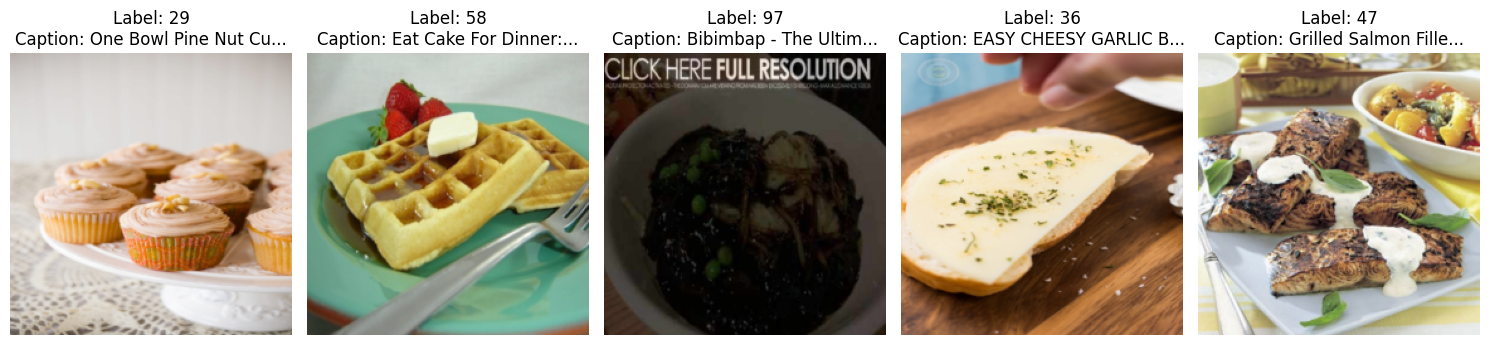

In [29]:
import matplotlib.pyplot as plt
import torch
import io
from PIL import Image

# Define the path and name of the dataset
DATA_DIR = "/content/drive/MyDrive"
DATA_NAME = "food101"

# Define image transformations
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test split of the dataset
test_dataset = MultimodalDataset(
    path=DATA_DIR,
    name=DATA_NAME,
    split="test",
    img_transforms=img_transforms
)

# Define the number of samples to display
num_samples = 5
indices = torch.randint(0, len(test_dataset), (num_samples,))

# Plot the images, captions, and labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(indices):
    image, text, label = test_dataset[idx]

    # Undo normalization for visualization
    image = image.permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = (image * 255).astype("uint8")

    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label}\nCaption: {text[:20]}...")  # Limit caption length

plt.tight_layout()
plt.show()


CLIP enables **zero-shot prediction**: the model can generalize to unseen datasets without explicitly training on them. Indeed, CLIP is pre-trained to determine whether an image and a text snippet form a matching pair within its dataset. This capability is repurposed for zero-shot classification. For a given dataset, the class names can be used as potential text pairings. CLIP predicts the most likely (image, text) pair by leveraging its pretrained alignment mechanism (see (3) in the figure above). Specifically, the image and text encoders generate feature embeddings for the image and the set of class names, respectively. The cosine similarity between these embeddings is calculated, scaled by a temperature parameter ($\tau$), and converted into a probability distribution using the softmax function.

### Question 2.3

Evaluate the zero-shot performance of the CLIP model on the UPMC-Food101 dataset. Use `clip.tokenize(text_labels)` to tokenize the text labels.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# To complete
# Load the test dataset
test_dataset = MultimodalDataset(
    path=DATA_DIR,
    name=DATA_NAME,
    split="test",
    img_transforms=preprocess
)

# Get class names (unique labels) from the dataset
class_names = list(set(test_dataset.labels))
text_labels = [f"A photo of a {class_name}." for class_name in class_names]

# Tokenize text labels
text_tokens = clip.tokenize(text_labels).to(device)

# Encode text labels
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize features

# Evaluate zero-shot accuracy
correct = 0
total = 0

for image, _, label in test_dataset:
    # Prepare the image
    image = image.unsqueeze(0).to(device)

    # Encode the image
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize features

    # Compute cosine similarities
    similarities = (image_features @ text_features.T).squeeze(0)

    # Compute probabilities
    probs = softmax(similarities / 1.0, dim=0)  # Temperature = 1.0

    # Get the predicted class
    predicted_class_idx = probs.argmax().item()
    predicted_class = class_names[predicted_class_idx]

    # Compare with ground truth
    if predicted_class == label:
        correct += 1
    total += 1

# Calculate accuracy
accuracy = correct / total
print(f"Zero-Shot Accuracy on UPMC-Food101: {accuracy * 100:.2f}%")


Zero-Shot Accuracy on UPMC-Food101: 1.58%


CLIP is composed of four main components:
- Vision encoder
- Text encoder
- A text and a visual projection heads to project the representations in the same space

#### Question 2.4
Finetune the text and image projection heads of CLIP using the UPMC-Food101 with the CLIP objective (as mentionned in the section introduction) between the image-text pairs for 100 epochs (for compute reason you can use only 5 to 10 epochs). Log both train and val losses.

Hparameters are to be choosen to your discretion.

Tips:
- You can use `torch.optim.SGD` for the optimizer
- You can use `model.visual.proj` and `model.text_projection` to access the projection heads of the model.
- For the loss, in CLIP, the similarity matrix between images and texts can be viewed as a classification problem:


**Illustration** for a batch size N=4:

| Text/Image | Img1 | Img2 | Img3 | Img4 |
|------------|------|------|------|------|
| Text1      | ✓    | ✗    | ✗    | ✗    |
| Text2      | ✗    | ✓    | ✗    | ✗    |
| Text3      | ✗    | ✗    | ✓    | ✗    |
| Text4      | ✗    | ✗    | ✗    | ✓    |

Think of each row as a text trying to "classify" which image it belongs to:

- Each text should pick its corresponding image (diagonal elements)
- The similarity scores can be treated as logits (pre-softmax probabilities)
- The "correct class" for Text1 is Img1, for Text2 is Img2, etc.

Thus, you can use the `CrossEntropyLoss` between your logits (as similarity scores) and the 'correct class'.

In [37]:
def finetune_clip(n_epochs, classes, batch_size, lr):
    """finetuning clip"""
    train_losses, val_losses = [], []
    model, _ = clip.load("ViT-B/32", device=device)
    # - Data
    im_transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) # To complete
    im_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) # To complete

    batch_size = batch_size # To complete
    dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="train",
                            img_transforms=im_transforms_train)
    test_dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=im_transforms)
    val_dataset = MultimodalDataset(path=DATA_DIR,
                                    name="food101",
                                    split="val",
                                    img_transforms=im_transforms)
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                drop_last=False)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  drop_last=False)
    # Finetuning - Freeze all parameters except projection heads
    for param in model.parameters():
        param.requires_grad = False
    model.visual.proj.requires_grad = True
    model.text_projection.requires_grad = True

    # Define optimizer and loss
    optimizer = SGD([model.visual.proj, model.text_projection], lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

     # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        for images, texts, _ in dataloader:
            images = images.to(device)

            # **Truncate long text descriptions**
            truncated_texts = [text[:70] + "..." if len(text) > 70 else text for text in texts]
            text_tokens = clip.tokenize(truncated_texts).to(device)

            # Forward pass
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_tokens)

            # Normalize features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Compute similarity logits
            logits_per_image = image_features @ text_features.T
            logits_per_text = text_features @ image_features.T

            # Ground truth labels
            labels = torch.arange(logits_per_image.size(0), device=device)

            # Compute loss
            loss = 0.5 * (criterion(logits_per_image, labels) + criterion(logits_per_text, labels))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Log train loss
        train_loss = running_train_loss / len(dataloader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, texts, _ in val_dataloader:
                images = images.to(device)

                # **Truncate long text descriptions**
                truncated_texts = [text[:70] + "..." if len(text) > 70 else text for text in texts]
                text_tokens = clip.tokenize(truncated_texts).to(device)

                # Forward pass
                image_features = model.encode_image(images)
                text_features = model.encode_text(text_tokens)

                # Normalize features
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                # Compute similarity logits
                logits_per_image = image_features @ text_features.T
                logits_per_text = text_features @ image_features.T

                # Ground truth labels
                labels = torch.arange(logits_per_image.size(0), device=device)

                # Compute loss
                loss = 0.5 * (criterion(logits_per_image, labels) + criterion(logits_per_text, labels))
                running_val_loss += loss.item()

        # Log val loss
        val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Return the fine-tuned model and loss history

    return model, train_losses, val_losses

Epoch [1/5], Train Loss: 2.9976, Val Loss: 2.9285
Epoch [2/5], Train Loss: 2.9060, Val Loss: 2.9066
Epoch [3/5], Train Loss: 2.8862, Val Loss: 2.8978
Epoch [4/5], Train Loss: 2.8755, Val Loss: 2.8932
Epoch [5/5], Train Loss: 2.8676, Val Loss: 2.8920


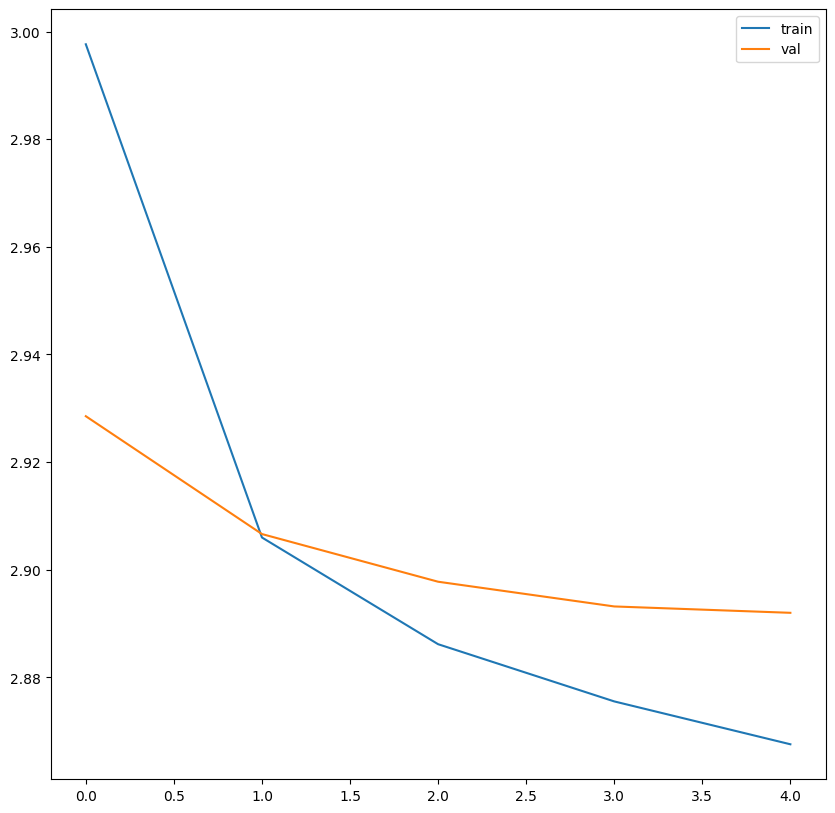

In [38]:
lr = 0.02 # Hparams to complete
batch_size = 32 # Hparams to complete
n_epochs = 5 # Hparams to complete
model, train_losses, val_losses = finetune_clip(n_epochs=n_epochs,
                                                classes=CLASSES_FOOD101,
                                                batch_size=batch_size,
                                                lr=lr)

# - Plot the losses
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

Results:
Hyperparameters:
```
lr = 0.01
batch_size = 32
n_epochs = 10
```
>Epoch [10/10], Train Loss: 2.8607, Val Loss: 2.8882